In [1]:
import sys
# Assuming we are in the notebook directory add this so that we can import the library
sys.path.append('..')

import time

import numpy as np
from abcpy.core import *
from abcpy.distributions import *
from abcpy.sequential_mc import SMC
from dask.dot import dot_graph
from functools import partial
import scipy.stats as ss

import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline


In [2]:
def normal_simu(n, mu, prng=None, latents=None):
    if latents is None:
        if prng is None:
            prng = np.random.RandomState()
        latents = prng.randn(n)
    u = mu + latents
    y = u
    return y

def mean(y):
    mu = np.mean(y, axis=1, keepdims=True)
    return mu

def distance(x, y):
    d = np.linalg.norm( np.array(x) - np.array(y), ord=2, axis=0)
    return d


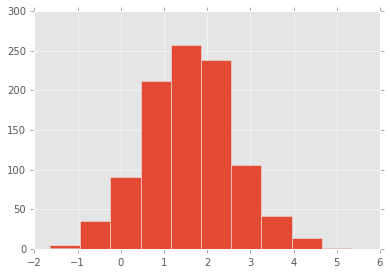

In [3]:
n = 1000
mu = 1.6

# Set up observed data y
latents = np.random.randn(n)
y = normal_simu(n, mu, latents=latents)

# Plot
plt.hist(y);

In [4]:
# Set up the simulator
simulator = partial(normal_simu, n)

# Specify the graphical model
mu = ScipyPrior('mu', ss.uniform, 0, 4)
Y = Simulator('normal_simu', simulator, mu, observed=y)
S1 = Summary('S1', mean, Y)
d = Discrepancy('d', distance, S1)

# Specify the number of simulations and set up rejection sampling
N = 10000
smc = SMC(N, d, [mu], 10000)

In [5]:
# Time and run parallel
s = time.time()
result = smc.infer(1, [0.1, 0.05, 0.025])
mu_post = result['samples'][0]

print("Elapsed time %d sec" % (time.time() - s))
print("Samples: {} ({:.2f}%)".format(len(mu_post), len(mu_post)/N*100))

Elapsed time 0 sec
Samples: 10000 (100.00%)


KeyError: 'threshold'

In [ ]:
if len(mu_post) > 0:
    print("Posterior for $\mu$")
    plt.hist(mu_post, bins=20)
else:
    print("No accepted samples")